I. Use ACF and PACF plots for order selection

We will start off with a **practice**:

For ts_1, ..., ts_4, use time series plot, ACF plot and PACF plot to answer

- is it statoinary
- if so, what model would you suggest to fit the data?

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings                               
warnings.filterwarnings('ignore')

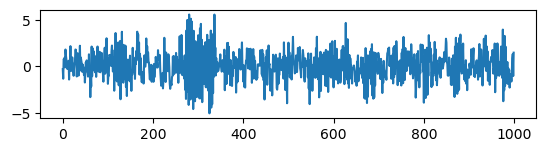

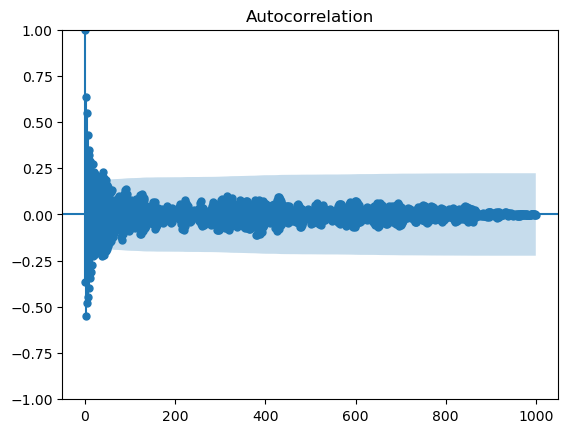

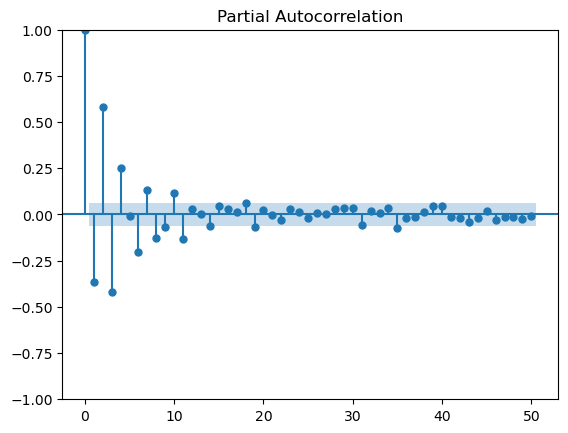

In [10]:
ts4 = pd.read_csv('./data/ts_4.csv')
plt.subplot(3,1,1)

plt.plot(ts4)
plt.show()

plot_acf(ts4,lags=999)
plot_pacf(ts4,lags=50)
plt.show()

II. Use AIC or BIC to do order selection

In [2]:
# data: simulate an ARMA(2,2) data
ar = np.array([1, -0.75,0.25])
ma = np.array([1,0.65, 0.35])
ARMA_object = ArmaProcess(ar, ma)
simulated_data = ARMA_object.generate_sample(nsample=500)

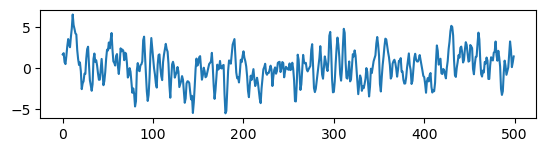

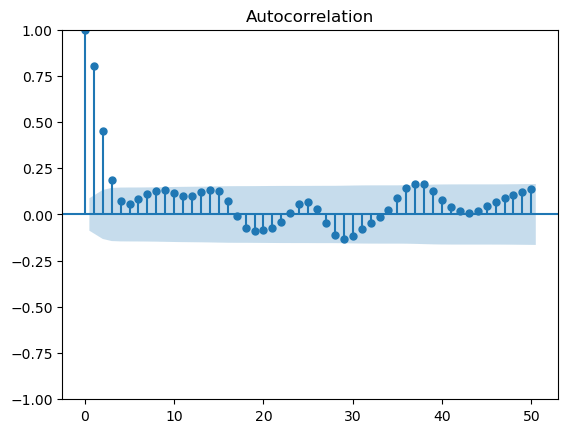

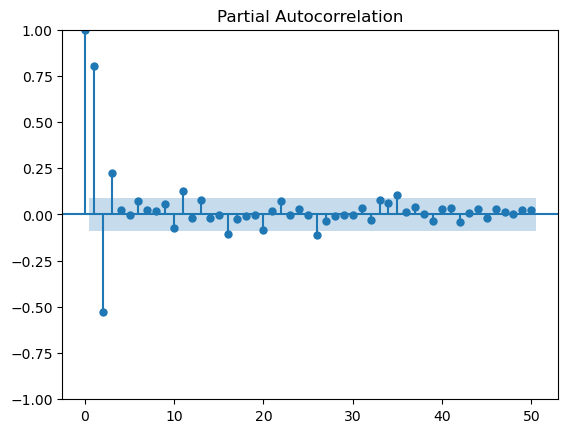

In [3]:
#1. Plots
plt.subplot(3,1,1)
plt.plot(simulated_data)
plt.show()
plot_acf(simulated_data,lags=50)
plt.show()
plot_pacf(simulated_data,lags=50)
plt.show()

In [4]:
#2. ARMA order selection using AIC or BIC
from statsmodels.tsa.stattools import arma_order_select_ic

arma_order_select_ic(simulated_data,max_ar=4, max_ma=4, ic='aic')

{'aic':              0            1            2            3            4
 0  2086.746236  1629.513002  1433.425264  1393.961503  1389.472062
 1  1574.615023  1419.714801  1387.633015  1388.717152  1391.407138
 2  1410.931808  1392.686138  1388.539909  1390.113150  1390.659138
 3  1387.209923  1388.659426  1389.193190  1392.537948  1386.921033
 4  1388.673109  1390.378449  1392.215418  1391.070954  1388.708629,
 'aic_min_order': (3, 4)}

In [5]:
arma_order_select_ic(simulated_data,max_ar=4, max_ma=4, ic='bic')

{'bic':              0            1            2            3            4
 0  2095.175452  1642.156826  1450.283696  1415.034543  1414.759711
 1  1587.258848  1436.573233  1408.706055  1414.004800  1420.909395
 2  1427.790241  1413.759178  1413.827558  1419.615407  1424.376002
 3  1408.282964  1413.947075  1418.695446  1426.254813  1424.852506
 4  1413.960757  1419.880706  1425.932283  1429.002427  1430.854710,
 'bic_min_order': (3, 0)}

In [11]:
from statsmodels.tsa.stattools import arma_order_select_ic

arma_order_select_ic(ts4,max_ar=4, max_ma=4, ic='aic')

{'aic':              0            1            2            3            4
 0  3791.545297  3726.753769  3496.610515  3338.341995  3165.051241
 1  3652.140283  3270.836749  2864.990073  2866.869104  2868.855132
 2  3241.137244  3049.652525  2866.868215  2868.278531  2870.245187
 3  3047.820180  3007.043691  2868.866222  2870.244435  2864.676194
 4  2983.413304  2985.398616  2867.067696  2872.200790  2867.472997,
 'aic_min_order': (3, 4)}

In [12]:
arma_order_select_ic(ts4,max_ar=4, max_ma=4, ic='bic')

{'bic':              0            1            2            3            4
 0  3801.360807  3741.477035  3516.241536  3362.880771  3194.497773
 1  3666.863549  3290.467771  2889.528850  2896.315636  2903.209419
 2  3260.768266  3074.191302  2896.314746  2902.632818  2909.507229
 3  3072.358957  3036.490223  2903.220509  2909.506477  2908.845992
 4  3012.859835  3019.752903  2906.329738  2916.370587  2916.550550,
 'bic_min_order': (1, 2)}

III. Train-validation split

Let's say we use 80-20 split and RMSE to select a model from ARMA(4,4) and ARMA (0,3)

In [6]:
train_ratio=0.8
X=simulated_data
arima_order=(3,0,0)

train_size = int(len(X) * train_ratio)
train, test = X[0:train_size], X[train_size:] #initial split of train and test
model = ARIMA(X[:train_size], order=arima_order) #each step: rolling one step forward to update the train set
model_fit = model.fit()

predictions=model_fit.forecast(len(test))
rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
rmse

1.9494339528992566

In [7]:
#you can write a function
def evaluate_arima_model(X, train_ratio, arima_order):
    train_size = int(len(X) * train_ratio)
    train, test = X[0:train_size], X[train_size:] #initial split of train and tes
    model = ARIMA(X[:train_size], order=arima_order) #each step: rolling one step forward to update the train set
    model_fit = model.fit()
    predictions=model_fit.forecast(len(test))
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    return rmse

In [8]:
evaluate_arima_model(simulated_data, 0.8, (3,0,0))

1.9494339528992566

In [9]:
evaluate_arima_model(simulated_data, 0.8, (2,0,3))

1.9488064970843404

If we want to do an automated search:

In [10]:
def evaluate_models(dataset, train_ratio, p_values, d_values, q_values):
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                rmse= evaluate_arima_model(dataset, train_ratio, order)
                result.append((order, rmse))
                if rmse < best_rmse:
                    best_rmse, best_cfg = rmse, order
                print('ARIMA%s RMSE=%.3f' % (order,rmse))
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_rmse))
    #return result


In [11]:
p_values = range(0, 4)
d_values = range(0, 1) #set d=0 for ARMA(p,q) model
q_values = range(0, 4)
evaluate_models(simulated_data, 0.8, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1.960
ARIMA(0, 0, 1) RMSE=1.959
ARIMA(0, 0, 2) RMSE=1.955
ARIMA(0, 0, 3) RMSE=1.951
ARIMA(1, 0, 0) RMSE=1.932
ARIMA(1, 0, 1) RMSE=1.942
ARIMA(1, 0, 2) RMSE=1.946
ARIMA(1, 0, 3) RMSE=1.948
ARIMA(2, 0, 0) RMSE=1.950
ARIMA(2, 0, 1) RMSE=1.950
ARIMA(2, 0, 2) RMSE=1.949
ARIMA(2, 0, 3) RMSE=1.949
ARIMA(3, 0, 0) RMSE=1.949
ARIMA(3, 0, 1) RMSE=1.950
ARIMA(3, 0, 2) RMSE=1.952
ARIMA(3, 0, 3) RMSE=1.949
Best ARIMA(1, 0, 0) RMSE=1.932


IV. Cross-validation

For example, if I want to search for ARMA orders using 3-fold CV for the best 10-day forecast:

- validation size = 10
- rolling window = 10
- initial train size=n-k*validation size = 470


In [12]:
def evaluate_models_cv(dataset, p_values, d_values, q_values):
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                validation_size=10
                train_size=470
                rmse=0
                for k in range(0,3):
                    train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+k*validation_size+10]
                    model = ARIMA(train, order=order) #each step: rolling one step forward to update the train se
                    model_fit = model.fit()
                    predictions=model_fit.forecast(len(test))
                    rmse = rmse+np.sqrt(skmetrics.mean_squared_error(test, predictions))
                rmse_avg=rmse/3
                result.append((order, rmse_avg))
                if rmse_avg < best_rmse:
                    best_rmse, best_cfg = rmse_avg, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse_avg))
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_rmse))
    #return result

In [13]:
p_values = range(0, 4)
d_values = range(0, 1) #set d=0 for ARMA(p,q) model
q_values = range(0, 4)
evaluate_models_cv(simulated_data, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1.622
ARIMA(0, 0, 1) RMSE=1.607
Best ARIMA(0, 0, 1) RMSE=1.607


<b> Practice</b>

Use `ts_5.csv` to practice order selection


1. Draw time series plot, ACF plot and PACF plot to have at least two candidate models. Use a 90-10 train-validation split to compare this two models. 
2. Run BIC selection for orders up to (4,4)
3. Your task is to forecast the next 5 steps. Holdoff the last 5 observations as test set. Use the historic 395 observations to design a cross-validation model selection. Choose one final model and report your test RMSE.